In [81]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [82]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, GlobalAveragePooling2D
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology as morph
from skimage import measure

In [83]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading the data

In [84]:
infile = open('Processed_Data_Classification.cp','rb')
data_dict = pickle.load(infile)
all_cts = data_dict['cts']
all_inf = data_dict['infects']
infile.close()

In [85]:
from sklearn.utils import shuffle
all_cts, all_inf = shuffle(all_cts, all_inf) #synchronized shuffling of data

In [86]:
all_cts = np.array(all_cts)
all_inf = np.array(all_inf)

In [87]:
print(all_cts.shape)
print(all_inf.shape)

(2063, 128, 128, 1)
(2063, 128, 128, 1)


In [88]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_inf = (all_inf - all_inf.min())/(all_inf.max()-all_inf.min())

In [89]:
print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_inf.min(), all_inf.max()))

0.0 1.0
0.0 1.0


# Creating labels

Number of CTS with no infection  499


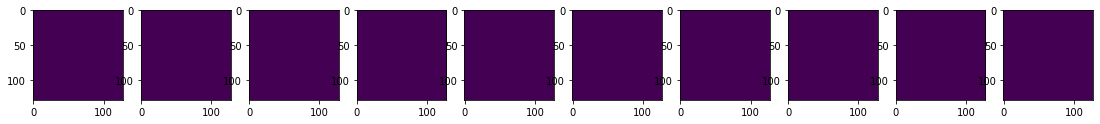

In [90]:
total_slides = len(all_cts)
index_arr = []
inf_check = np.ones((len(all_inf)))
for i in range(len(all_inf)):
  if np.unique(all_inf[i]).size == 1:
    inf_check[i] = 0
    index_arr.append(i)

print("Number of CTS with no infection ", len(index_arr))

fig, axes = plt.subplots(1, 10, figsize=(19,9))
tmp = 0
for i in index_arr:
  img_inf = cv.resize(all_inf[i], dsize=(128, 128), interpolation=cv.INTER_AREA)
  axes[tmp].imshow(img_inf)
  tmp += 1
  if tmp==10:
    break

# Splitting the data

In [91]:
X_train = all_cts[:int(len(all_cts)*0.6)]
Y_train = inf_check[:int(len(inf_check)*0.6)]
X_val = all_cts[int(len(all_cts)*0.6):int(len(all_cts)*0.8)]
Y_val = inf_check[int(len(inf_check)*0.6):int(len(inf_check)*0.8)]
X_test = all_cts[int(len(all_cts)*0.8):]
Y_test = inf_check[int(len(inf_check)*0.8):]

In [92]:
X_test_inf = all_inf[int(len(all_inf)*0.8):]

In [93]:
print("{} {}".format(X_train.shape, Y_train.shape))
print("{} {}".format(X_val.shape, Y_val.shape))
print("{} {}".format(X_test.shape, Y_test.shape))

(1237, 128, 128, 1) (1237,)
(413, 128, 128, 1) (413,)
(413, 128, 128, 1) (413,)


# Defining the Neural network

In [94]:
def get_model(width=128, height=128):

    inputs = Input((width, height, 1))

    x = Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = Model(inputs, outputs, name="2dcnn")
    return model

In [95]:
model = get_model(width=128, height=128)
model.summary()

Model: "2dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 63, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 64)        256   

# Compiling the model

In [96]:
initial_learning_rate = 0.0001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)
checkpoint_cb = callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

# Training

In [97]:
history = model.fit(X_train, Y_train, epochs = 100, validation_data = (X_val, Y_val), callbacks = [checkpoint_cb],  shuffle=True, verbose=1)

Epoch 1/100
39/39 [==============================] - 2s 23ms/step - loss: 0.6364 - acc: 0.6572 - val_loss: 0.6193 - val_acc: 0.7821
Epoch 2/100
39/39 [==============================] - 1s 18ms/step - loss: 0.4620 - acc: 0.8020 - val_loss: 0.7338 - val_acc: 0.2179
Epoch 3/100
39/39 [==============================] - 1s 18ms/step - loss: 0.3240 - acc: 0.8980 - val_loss: 1.2067 - val_acc: 0.2179
Epoch 4/100
39/39 [==============================] - 1s 18ms/step - loss: 0.2694 - acc: 0.9112 - val_loss: 1.9332 - val_acc: 0.2179
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 0.2493 - acc: 0.8962 - val_loss: 0.7240 - val_acc: 0.2179
Epoch 6/100
39/39 [==============================] - 1s 18ms/step - loss: 0.1909 - acc: 0.9432 - val_loss: 0.9314 - val_acc: 0.2179
Epoch 7/100
39/39 [==============================] - 1s 18ms/step - loss: 0.1631 - acc: 0.9473 - val_loss: 0.7583 - val_acc: 0.2179
Epoch 8/100
39/39 [==============================] - 1s 18ms/step - loss: 0.

# Plotting the accuracy and loss

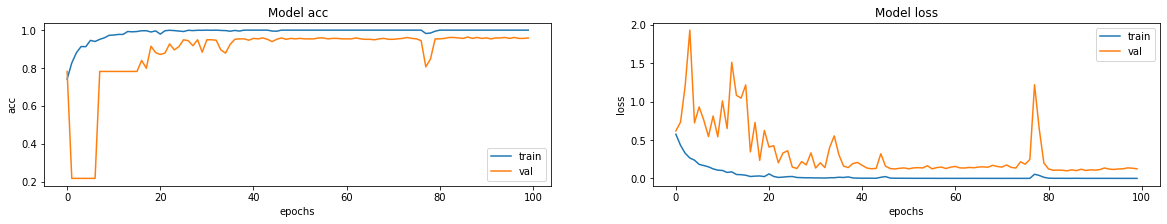

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Predicting on the test dataset

In [99]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(X_test)

# Calculating optimal threshold

In [100]:
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(Y_test,prediction)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
prediction = prediction > optimal_threshold

# Calculating precision, recall and F1 score

Precision: 0.99 and Recall: 0.9310344827586207
F1 score: 0.9596122778675282


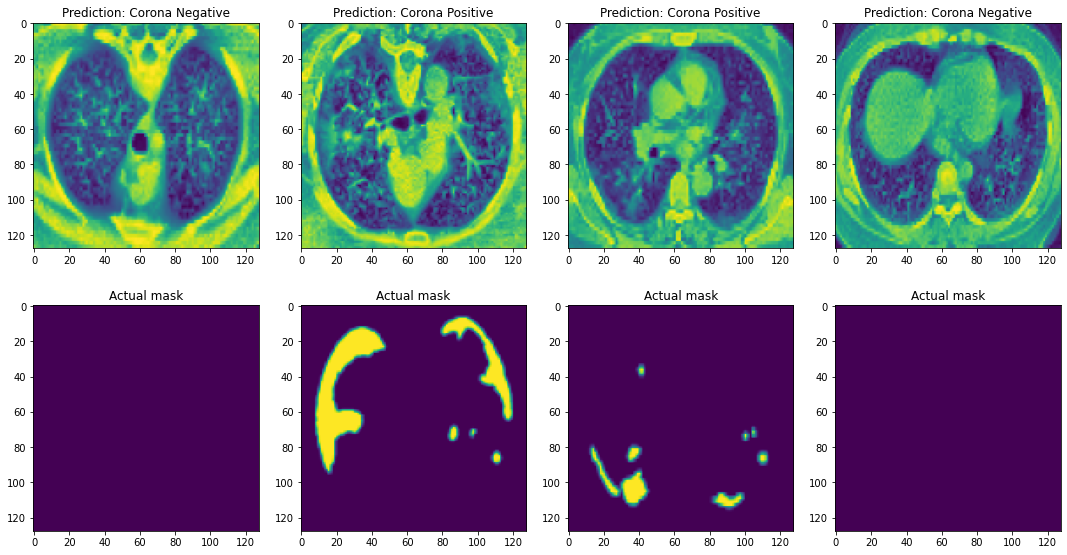

In [103]:
tn, fp, fn, tp = mt.confusion_matrix(Y_test, prediction).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {} and Recall: {}".format(precision, recall))
print("F1 score: {}".format(2*precision*recall/(precision+recall)))
import random
fig, axes = plt.subplots(2, 4, figsize=(15,8))
fig.tight_layout()
for i in range(4):
    c = random.randint(0,prediction.shape[0]-1)
    axes[0,i].imshow(np.squeeze(X_test[c]))
    result = 'res'
    if(prediction[c]): 
      result = 'Positive'
    else: 
      result = 'Negative'
    axes[0,i].set_title('Prediction: Corona {}'.format(result))
    axes[1,i].imshow(np.squeeze(X_test_inf[c]))
    axes[1,i].set_title('Actual mask')